## Fully connected LSTM

Background: Since, we are predicting the future trajectory of a storm through time it makes the most sense if we use a neural network that suits sequential dataset. This has inspired us to use LSTM. The way the algorithm works is by converting the images(2D) into a 1 dimensional array, put it into the LSTM model and predict the next step and convert it back to the same 2D image.

The way we load the data has been inspired by the nasa website. https://nbviewer.org/github/radiantearth/mlhub-tutorials/blob/main/notebooks/NASA%20Tropical%20Storm%20Wind%20Speed%20Challenge/nasa-tropical-storm-wind-speed-challenge-getting-started.ipynb

In [1]:
## Pre-installation
! pip install radiant-mlhub
! pip install livelossplot
! pip install pytorch-msssim
! pip install -q pycm livelossplot
%pylab inline
! pip install pycm
# ! mlhub configure
# # my API key: 5f67f7a7e9c18910f4718ba4db64d107850aec565adbe587aca3bd99a8c0e1a4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Populating the interactive namespace from numpy and matplotlib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We import all the required packages including the modules we have created in a folder called tools. (Note: importing in local machine and in colab is different because in google colab we cannot install our created module, but you can do this in a local environment)

In [4]:
# imports
import os
import tarfile
from sklearn.metrics import accuracy_score

import numpy as np
import random
from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage
from radiant_mlhub import Dataset
from torchvision.transforms.transforms import Resize
from torchvision import transforms
from PIL import Image as pil_image

# Importing team's Andrew module for local machine(after installing our modules)
# import tools.dataprocessing as dataprocessing
# import tools.visualisation as visualisation
# import tools.fc_lstm as fc_lstm
# import tools.fc_lstm_pca as fc_lstm_pca

# For colab it is not possible to setup the model so we just load the py files directly
import dataprocessing as dataprocessing
import visualisation as visualisation
import fc_lstm as fc_lstm
import fc_lstm_pca as fc_lstm_pca
import metric as metric


device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


# Downloading the dataset

Firstly, we have to paste the required .tar.gz file into the current directory, then we can run the cell below. This will extract all the tar.gz files

In [5]:
# # Download the dataset
# os.environ['MLHUB_API_KEY'] = '5f67f7a7e9c18910f4718ba4db64d107850aec565adbe587aca3bd99a8c0e1a4'
# dataset = Dataset.fetch('nasa_tropical_storm_competition')
# for c in dataset.collections:
#     print(c.id)

# # download the dataset
# dataset.download(output_dir='.')

# unzip the dataset
for path, directories, files in os.walk('./'):
    for f in files:
        if f.endswith(".tar.gz"):
            tar = tarfile.open(os.path.join(path,f), 'r:gz')
            tar.extractall(path=path)
            tar.close()

We load the training data. Using the full dataset we add additional columns called file_name and images_per_storm. Originally, the images_per_storm column was used so that we could look at all the storms and filter the most interesting storm, but as we are performing this on the surprise data, there would be no need for the images_per_storm column.
More information of this function can be found in the docstrings(Andrew.pdf). We will split this data later on

In [6]:
import pandas as pd
train_df = dataprocessing.Load_data_to_train("nasa_tropical_storm_competition_surprise_storm_source", "nasa_tropical_storm_competition_surprise_storm_labels", "./")
full_df = dataprocessing.manipdata_surprise(train_df)

In [7]:
full_df.head()

,Image ID,Storm ID,Relative Time,Ocean,Wind Speed,file_name,images_per_storm
0,sss_001,sss,437401,1,120,./nasa_tropical_storm_competition_surprise_sto...,100
1,sss_002,sss,439200,1,121,./nasa_tropical_storm_competition_surprise_sto...,100
2,sss_003,sss,442800,1,124,./nasa_tropical_storm_competition_surprise_sto...,100
3,sss_004,sss,448200,1,128,./nasa_tropical_storm_competition_surprise_sto...,100
4,sss_005,sss,453600,1,130,./nasa_tropical_storm_competition_surprise_sto...,100


More data processing...

In [8]:
x_full = full_df.drop("Wind Speed", axis=1) # Separating out windspeed from the dataframe
y_full = full_df['Wind Speed'] # Put the windspeed as a label

# Full data

## Should we Normalize?

We have tried to trained our data without normalizing, however the training values were stocastic and didn't vary in a smooth manner, this could be due to exploding MSEs. Since our data isn't normalized. To see this, remove the variable old_mean and old_std (see comments below)

In [9]:
# Turning dataset into tensor, grayscaling it
full_dataset = dataprocessing.DatasetSTORM(x_full, y_full)
# Put the data into dataloader with batch size = 1
full_loader = DataLoader(full_dataset, num_workers=0, batch_size=1)
# turn our loader into 1D array containing image ID, the images and the labels
image_id_full, images_full, labels_full = dataprocessing.Loader_to_1D_array(full_loader, 366*366)
# We will only consider the images here due to limiting time, if we had more time we could implement
# the wind speed(label) as well
Full_data = torch.stack(images_full)
old_mean = torch.mean(Full_data)
old_std = torch.std(Full_data)
print(torch.mean(Full_data))
print(torch.std(Full_data))

tensor(0.4506)
tensor(0.2148)


From here onwards, we will only look at the images instead of the label(wind speed), if given more time we could've added wind speed as another variable to improve our result.

The way we turn the data into tensor, grayscale and normalize (if choose to) is inspired from this link

https://nbviewer.org/github/radiantearth/mlhub-tutorials/blob/main/notebooks/NASA%20Tropical%20Storm%20Wind%20Speed%20Challenge/nasa-tropical-storm-wind-speed-challenge-benchmark.ipynb

In [10]:
train_size = 95 # Choose training data size
val_size = 0 # Choose validation size
test_size = 5 # Choose testing size
old_mean = 0 # Remove this line if you want to normalize
old_std = 1 # Remove this line if you want to normalize

# Here we split, normalize with the previous mean and standard deviation, turn the data into the tensor, 
full_dataset, train_dataset, val_dataset, test_dataset = dataprocessing.SplitData(x_full, y_full, train_size, val_size, test_size, dataprocessing.DatasetSTORM, old_mean, old_std)

full data:  100 
Train_size:  95 
val_size: 0 
test_size:  6


In [11]:
# Dataload our splitted data into a loader variable
full_loader = DataLoader(full_dataset, num_workers=0, batch_size=1)
train_loader = DataLoader(train_dataset, num_workers=0, batch_size=1)
val_loader = DataLoader(val_dataset, num_workers=0, batch_size=1)
test_loader = DataLoader(test_dataset, num_workers=0, batch_size=1)

## Visualize the first few plots

We will look at the first few (when the storm starts).

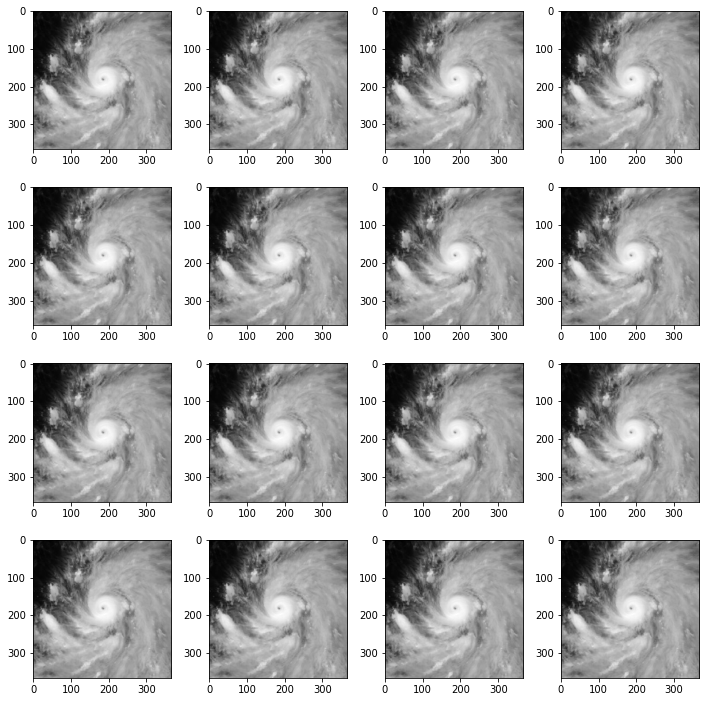

In [12]:
for image in full_loader:
    visualisation.show_batch(image,4,4)
    break

We store the images in an array

In [13]:
# Here we store the images in an array for the whole dataset, training, validation and testing
image_id_full, images_full, labels_full = dataprocessing.Loader_to_1D_array(full_loader, 366*366)
image_id, images, labels = dataprocessing.Loader_to_1D_array(train_loader, 366*366)
image_id_val, images_val, labels_val = dataprocessing.Loader_to_1D_array(val_loader, 366*366)
image_id_test, images_test, labels_test = dataprocessing.Loader_to_1D_array(test_loader, 366*366)

Sanity check whether our data has been normalized if we had normalized before

In [14]:
# full_image = torch.stack(images_full)
# print(torch.mean(full_image))
# print(torch.std(full_image))

## Putting the data into the right format for training and testing

**Note**: tw is train window

Our algorithm involves putting an image into the neural network and predicting the next image. Hence, we will split the training and labelling data in a manner that we take the first tw images take the next image as the testing data.

The network is inspired from https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/
where they predict a time series data, but in our case we are predicting a whole array rather than an integer.

For example, if we had 10 datapoints in total and our tw value is 2 then,
our training and labelling data would be

(1,2), 3

(2,3), 4

(3,4), 5

and so on..

In this case we choose the tw value to be 1

In [15]:
# Creating training and labelling variable to directly use in our training
training, labeling = dataprocessing.create_inout_seq(images, 1)

# validating, labeling_val = create_inout_seq(images_val, 1)

# Creating training and labelling variable to directly use in our training
testing, labeling_test = dataprocessing.create_inout_seq(images_test, 1)

In [16]:
storm_train = TensorDataset(training, labeling)
# storm_val = TensorDataset(validating, labeling_val)
storm_test = TensorDataset(testing, labeling_test)

## Training our model

### Using MSE

We will train our model with 2 different metric, the MSE and the SSIM metric.

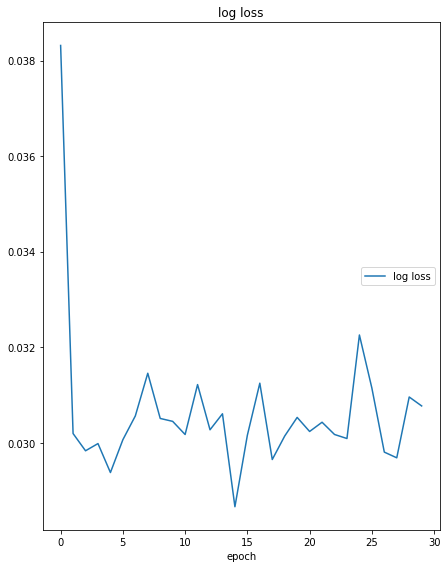

log loss
	log loss         	 (min:    0.029, max:    0.038, cur:    0.031)
135.1490330696106


In [17]:
from livelossplot import PlotLosses
import time
fc_lstm.set_seed(42)
epochs = 30
batch_size = 1
model_MSE = fc_lstm.LSTM(366*366, 150, 366*366).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_MSE.parameters(), lr=0.01)
train_loader = DataLoader(storm_train, batch_size=batch_size, shuffle=True, num_workers=0)
# val_loader = DataLoader(storm_val, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(storm_test, batch_size=batch_size, shuffle=True, num_workers=0)
# model.hidden_layer_size = batch_size

liveloss = PlotLosses()
start = time.time()
for i in range(epochs):
    logs = {}
    train_loss = fc_lstm.train_lstm_mse(model_MSE, optimizer, criterion, train_loader)
    # Additional line for giving logs in liveloss plot
    logs['' + 'log loss'] = train_loss.item()

    # validation_loss= fc_lstm.validate_mse(model, criterion, val_loader)
    # # Additional line for giving logs in liveloss plot
    # logs['val_' + 'log loss'] = validation_loss.item()

    liveloss.update(logs)
    liveloss.draw()

end = time.time()
print(end - start)

# Using SSIM

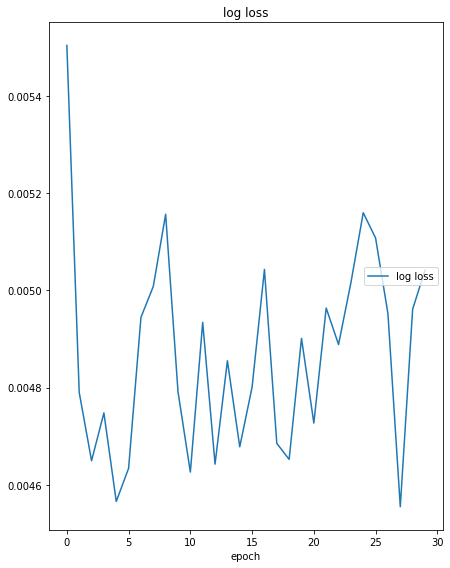

log loss
	log loss         	 (min:    0.005, max:    0.006, cur:    0.005)
140.10765671730042


In [18]:
from livelossplot import PlotLosses
import time
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
fc_lstm.set_seed(42)
epochs = 30
batch_size = 1
model_ssim = fc_lstm.LSTM(366*366, 150, 366*366).to(device)
criterion = ssim
optimizer = torch.optim.Adam(model_ssim.parameters(), lr=0.01)
train_loader = DataLoader(storm_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(storm_test, batch_size=batch_size, shuffle=True, num_workers=0)

liveloss = PlotLosses()
start = time.time()
for i in range(epochs):
    logs = {}
    train_loss = fc_lstm.train_lstm_SSIM(model_ssim, optimizer, criterion, train_loader)
    # Additional line for giving logs in liveloss plot
    logs['' + 'log loss'] = train_loss.item()

    # validation_loss= validate(model, criterion, val_loader)
    # # Additional line for giving logs in liveloss plot
    # logs['val_' + 'log loss'] = validation_loss.item()

    liveloss.update(logs)
    liveloss.draw()

end = time.time()
print(end - start)
# print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

From this we see that using fully connected LSTM gives a very stocastic training loss curve, so pure fully connected LSTM might not be the best method, However let us see the results first.

# Prediction for fully connected LSTM

## Future 5 predictions

From training with MSE

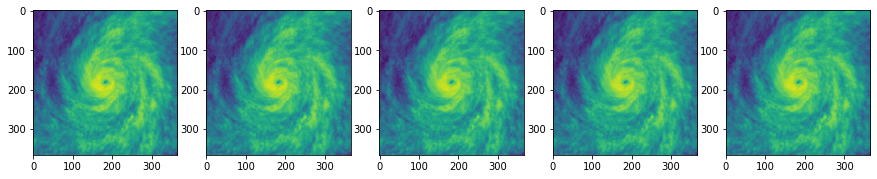

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 1
y_pred_MSE, ys_MSE= fc_lstm.evaluate(model_MSE, test_loader)
y_pred_MSE = y_pred_MSE.reshape(5,366,366)
for i in range(1, columns*rows +1):
    # print(np.shape(y_pred))
    fig.add_subplot(rows, columns, i)
    # img = Image.fromarray(np.uint8(y_pred[i-1]*255), "L")
    # img.save(f'storm_prediction{i}.png')
    # print(img)
    plt.imshow(y_pred_MSE[i-1])
    # img.show()
plt.show()
# img.save("filename.jpeg")

From training with SSIM

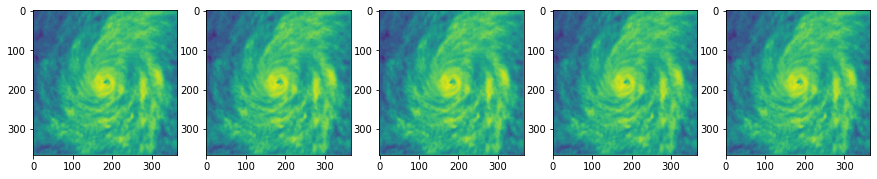

In [20]:
import numpy as np
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 1
y_pred_ssim, ys= fc_lstm.evaluate(model_ssim, test_loader)
y_pred_ssim = y_pred_ssim.reshape(5,366,366)
for i in range(1, columns*rows +1):
    # print(np.shape(y_pred))
    fig.add_subplot(rows, columns, i)
    plt.imshow(y_pred_ssim[i-1])
plt.show()

## The actual Next 5 predictions

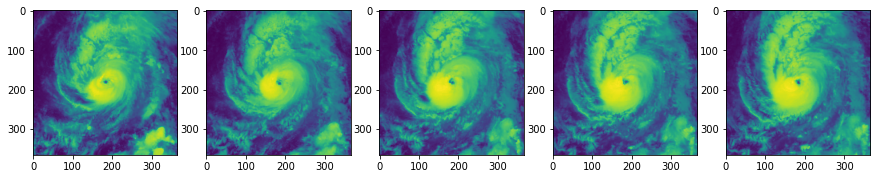

In [21]:
import numpy as np
import matplotlib.pyplot as plt

current = 94
w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 1
for i in range(1, columns*rows +1):
    img = images_full[current+i:current+i+1][0].reshape(366,366)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

Here we see that our model haven't capture the dark edges of the storm very well and the structure of the storm looks slightly different

## The error metric for training with fully connected LSTM with MSE

We will now evaluate the SSIM and MSE metric. To calculate this make sure that in the current repository, there exists 5 real images ie. "Real1.jpg", "Real2.jpg", "Real3.jpg", "Real4.jpg", "Real5.jpg" inorder to calculate this metric

In [24]:
ssim_arr, mse_arr = metric.Generate_ssim_mse(y_pred_MSE,"Real")

96 th image ssim:  0.27051699870703644 MSE 2688.1722207291946
97 th image ssim:  0.24513039985513646 MSE 2883.9712517543076
98 th image ssim:  0.24952245494521272 MSE 2732.6778195825495
99 th image ssim:  0.25223068010428323 MSE 2714.999089253188
100 th image ssim:  0.259857800868099 MSE 2823.8525262026337


The error metric for training with fully connected LSTM with MSE

In [25]:
ssim_arr, mse_arr = metric.Generate_ssim_mse(y_pred_ssim,"Real")

96 th image ssim:  0.27438267650090675 MSE 3805.246088267789
97 th image ssim:  0.24990162289107903 MSE 4063.010137657141
98 th image ssim:  0.25684119898775504 MSE 3736.8109901758785
99 th image ssim:  0.26272547813030633 MSE 3560.971610080922
100 th image ssim:  0.26632224499202894 MSE 3567.9268117889455


We see that the MSE from using the nn.MSELoss() function is better than using ssim as a loss function. We suspect that the large pixel size might lead to the error in predicting, so in the following section we will try to use PCA with LSTM

## Fully connected LSTM with PCA

We train the pca and transform our data inorder to be inserted into our network again

In [26]:
from sklearn.decomposition import PCA
# Reshaping the images for PCA
train_image = torch.stack(images)
test_image = torch.stack(images_test)
train_pca = train_image.reshape(-1,366*366)
test_pca = test_image.reshape(-1,366*366)
# train_image.shape

# Training the PCA and reducing the dimension of the dataset
pca_train= PCA(n_components=93)  
pca_train_dataset = pca_train.fit_transform(train_pca)
pca_test_dataset = pca_train.transform(test_pca)
print("explained variance: ", sum(pca_train.explained_variance_ratio_))

# Putting the data in the required format
pca_train_data = torch.from_numpy(pca_train_dataset).float()
pca_test_data = torch.from_numpy(pca_test_dataset).float()

# Generating the training and testing set like previously
training, labeling = dataprocessing.create_inout_seq_pca(pca_train_data, 1)
testing, labeling_test = dataprocessing.create_inout_seq_pca(pca_test_data, 1)

storm_train = TensorDataset(training, labeling)
storm_test = TensorDataset(testing, labeling_test)

explained variance:  0.9993289857843587


## Grid Search
We perform grid search inorder to select the best hyperparameter between learning rate and the number of hidden layer. 



In [27]:
from livelossplot import PlotLosses
import time
# grid search
lr_range = [0.001,0.01]
hidden_layers = [100,500,700,1000]
loss_table = np.zeros((len(hidden_layers), len(lr_range)))
epochs = 100

# fixedcprameters
fc_lstm.set_seed(42)
batch_size = 1

criterion = nn.MSELoss()
 
train_loader = DataLoader(storm_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(storm_test, batch_size=batch_size, shuffle=True, num_workers=0)
 
# liveloss = PlotLosses()
# start = time.time()
 
for i in range(len(hidden_layers)):
 for j in range(len(lr_range)):
  model_grid = fc_lstm.LSTM(93, hidden_layers[i], 93).to(device)
  optimizer = torch.optim.Adam(model_grid.parameters(), lr=lr_range[j])
  
  # liveloss = PlotLosses()
  start = time.time()
  for k in range(epochs):
    # logs = {}
    train_loss = fc_lstm.train_lstm_mse(model_grid, optimizer, criterion, train_loader)
    
  loss_table[i][j] = train_loss.item()
  end = time.time()
  print("finish!",hidden_layers[i],lr_range[j],loss_table[i][j],end - start)
  
  # print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

finish! 100 0.001 2.88179874420166 15.667436838150024
finish! 100 0.01 1.9497169256210327 15.785802841186523
finish! 500 0.001 0.005863979458808899 15.386897563934326
finish! 500 0.01 1.0174627304077148 15.419873237609863
finish! 700 0.001 0.03513740375638008 18.349520921707153
finish! 700 0.01 1.6363029479980469 18.25740933418274
finish! 1000 0.001 0.06578157842159271 25.283541202545166
finish! 1000 0.01 3.4308576583862305 25.341166019439697


In [28]:
import prettytable as pt
 
#define head
head = [" hidden-layer \ learnning rate ", 0.001,0.01]
 
# change format for printing
loss_table = loss_table.tolist()
loss_table[0] = np.append(hidden_layers[0], loss_table[0] )
loss_table[1] = np.append(hidden_layers[1], loss_table[1] )
loss_table[2] = np.append(hidden_layers[2], loss_table[2] )
loss_table[3] = np.append(hidden_layers[3], loss_table[3] )
print("Grid Search table of loss: \n")
 
loss_t = pt.PrettyTable()
loss_t.field_names = head
loss_t.add_row(loss_table[0])
loss_t.add_row(loss_table[1])
loss_t.add_row(loss_table[2])
loss_t.add_row(loss_table[3])
print(loss_t)

Grid Search table of loss: 

+---------------------------------+----------------------+--------------------+
|  hidden-layer \ learnning rate  |        0.001         |        0.01        |
+---------------------------------+----------------------+--------------------+
|              100.0              |   2.88179874420166   | 1.9497169256210327 |
|              500.0              | 0.005863979458808899 | 1.0174627304077148 |
|              700.0              | 0.03513740375638008  | 1.6363029479980469 |
|              1000.0             | 0.06578157842159271  | 3.4308576583862305 |
+---------------------------------+----------------------+--------------------+


Here we see that the optimal number of hidden layer is 500 with a learning rate of 0.001. Also, We decided to use 50 epochs to avoid overfitting

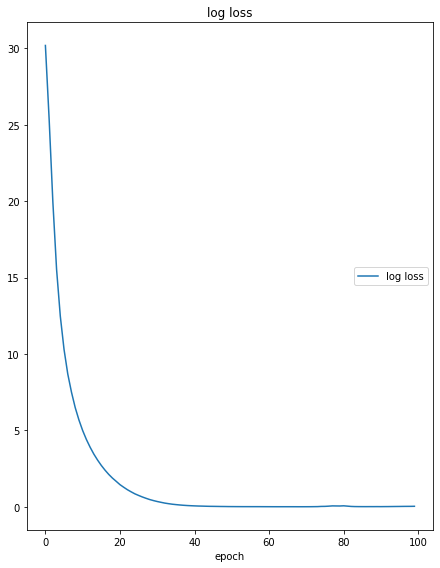

log loss
	log loss         	 (min:    0.005, max:   30.195, cur:    0.034)
39.07702565193176


In [73]:
from livelossplot import PlotLosses
import time
fc_lstm.set_seed(42)
epochs = 100
batch_size = 1
model_LSTM_PCA = fc_lstm.LSTM(93, 500, 93).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_LSTM_PCA.parameters(), lr=0.001)
train_loader = DataLoader(storm_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(storm_test, batch_size=batch_size, shuffle=True, num_workers=0)

liveloss = PlotLosses()
start = time.time()
for i in range(epochs):
    logs = {}
    train_loss = fc_lstm.train_lstm_mse(model_LSTM_PCA, optimizer, criterion, train_loader)
    # Additional line for giving logs in liveloss plot
    logs['' + 'log loss'] = train_loss.item()

    # validation_loss= validate(model, criterion, val_loader)
    # # Additional line for giving logs in liveloss plot
    # logs['val_' + 'log loss'] = validation_loss.item()

    liveloss.update(logs)
    liveloss.draw()

end = time.time()
print(end - start)
# print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

Our curve is much smoother than training with fully connected LSTM without PCA

Our prediction

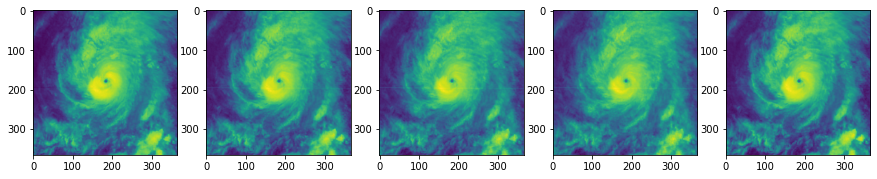

In [74]:
import numpy as np
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 1
y_pred_LSTM_PCA, ys= fc_lstm_pca.evaluate_pca(model_LSTM_PCA, test_loader, pca_train)
y_pred_LSTM_PCA = y_pred_LSTM_PCA.reshape(5,366,366)
for i in range(1, columns*rows +1):
    # print(np.shape(y_pred))
    fig.add_subplot(rows, columns, i)
    plt.imshow(y_pred_LSTM_PCA[i-1])
plt.show()

Our image captures the edges better now and our structure looks more similar to the actual image as seen below

Actual Image

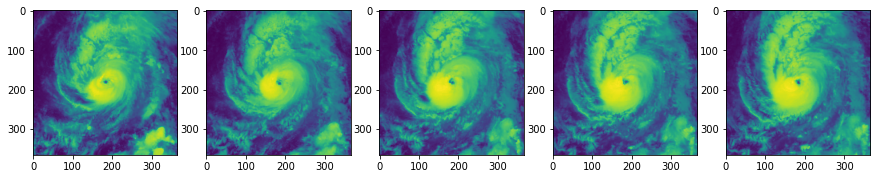

In [75]:
import numpy as np
import matplotlib.pyplot as plt

current = 94
w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 1
for i in range(1, columns*rows +1):
    img = images_full[current+i:current+i+1][0].reshape(366,366)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [76]:
ssim_arr, mse_arr = metric.Generate_ssim_mse(y_pred_LSTM_PCA,"Real")

96 th image ssim:  0.4814471386405817 MSE 541.1157768222402
97 th image ssim:  0.35895079530654717 MSE 1069.069888620144
98 th image ssim:  0.34979705241415326 MSE 1235.5056436441816
99 th image ssim:  0.3367076794511068 MSE 1405.105445071516
100 th image ssim:  0.3166338878148555 MSE 1799.8346770581386


We see that as we predict further generally, our MSE would increase. This make sense because we are using our predicted result to predict the next result.